<a href="https://colab.research.google.com/github/chandan110791/CNN_Skin_Cancer_Prediction_Assignment/blob/master/chandan_kumar_singh_skin_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem statement: **

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

**Reading the Data**

### Importing all the important libraries

In [36]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D ,BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.regularizers import l2
import tensorflow

In [37]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [38]:
#Test Mounting and exact path and rad-wrtie permission

with open('/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/foo.txt

Hello Google Drive!

In [39]:
!pip install tensorflow==2.9.1
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [40]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
train_path= "/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/"
test_path="/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Test/"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [41]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Dataset Creation 

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [42]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [43]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [44]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [45]:
## test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [46]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Dataset visualization


In [47]:
#class_names=np.array(class_names)

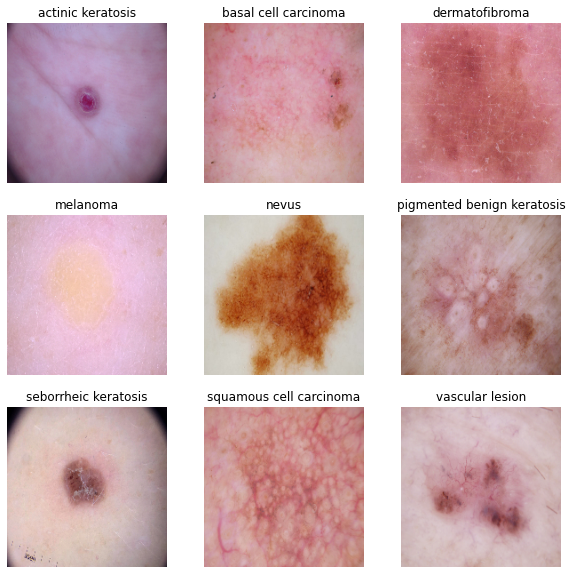

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    #plt.title(class_names[i] for i in labels)
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [49]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [50]:
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [51]:


### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "categorical_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])


### Train the model

In [52]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

model.summary()

Epoch 1/20
56/56 [==============================] - 16s 74ms/step - loss: 2.7548 - accuracy: 0.2003 - val_loss: 1.9527 - val_accuracy: 0.2864
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.7724 - accuracy: 0.3700 - val_loss: 1.6439 - val_accuracy: 0.4564
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6222 - accuracy: 0.4347 - val_loss: 1.6050 - val_accuracy: 0.5056
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.5026 - accuracy: 0.4782 - val_loss: 1.4618 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4100 - accuracy: 0.4967 - val_loss: 1.4993 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3390 - accuracy: 0.5324 - val_loss: 1.3919 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.2364 - accuracy: 0.5469 - val_loss: 1.4185 - val_accuracy: 0.5123
Epoch 8/20
5

### Visualizing training results

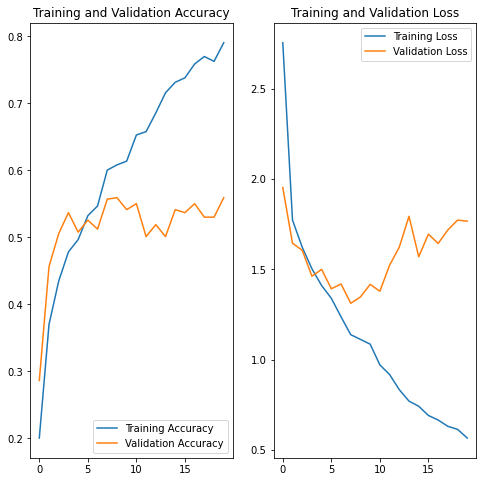

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [54]:
# Model Overfit or Underfit?
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 12ms/step - loss: 1.7666 - accuracy: 0.5593
Accuracy:  0.8660714030265808
Validation Accuracy:  0.5592840909957886
Loss:  0.3814202845096588
Validation Loss 1.7665611505508423


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit





### Write your findings here

4.5 Observations

    The accuracy of the model for the Training data set is at 92%. But the Validation accuracy is not in par with the training accuracy. The validation loss as observed is very high.
    This could also be indicative of some Overfit in the model.
    We could add some Dropout layers and remove the BatchNormalization layers.
    And by adding a few more layers, we could improve the accuracy by trying to extract more features.


In [55]:
# Create another model 

model_update=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

In [56]:
# Compile 



model_update.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')



In [57]:
#Train 

## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 59ms/step - loss: 2.1377 - accuracy: 0.1897 - val_loss: 2.0487 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 59ms/step - loss: 2.0321 - accuracy: 0.1959 - val_loss: 2.0334 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 3s 58ms/step - loss: 2.0373 - accuracy: 0.2126 - val_loss: 2.0279 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.9968 - accuracy: 0.2623 - val_loss: 2.0584 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.9930 - accuracy: 0.2494 - val_loss: 1.9998 - val_accuracy: 0.2349
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.9037 - accuracy: 0.2729 - val_loss: 1.7896 - val_accuracy: 0.3423
Epoch 7/20
56/56 [==============================] - 3s 56ms/step - loss: 1.8104 - accuracy: 0.3371 - val_loss: 1.8622 - val_accuracy: 0.2796
Epoch 8/20
56

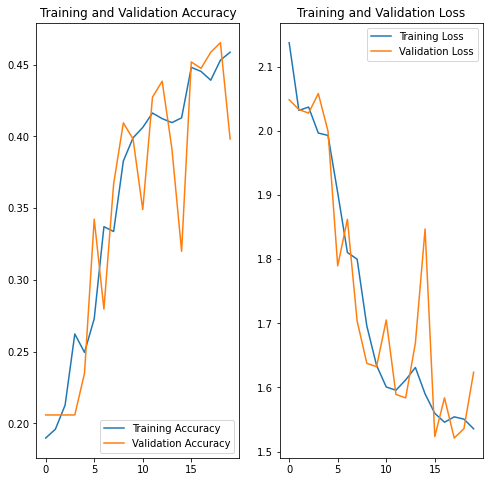

In [58]:
# Visualize again .



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [59]:
loss, accuracy = model_update.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model_update.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 20ms/step - loss: 1.6237 - accuracy: 0.3982
Accuracy:  0.42578125
Validation Accuracy:  0.3982102870941162
Loss:  1.5668061971664429
Validation Loss 1.623721957206726


Observations

    The model accuracy for Train data set has dropped . 
    The accuracy for the Validation set too.
    This is a much better model compared to the previous model as there seems to be No Overfit with the training accuracy  and validation accuracy .


In [60]:


data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])



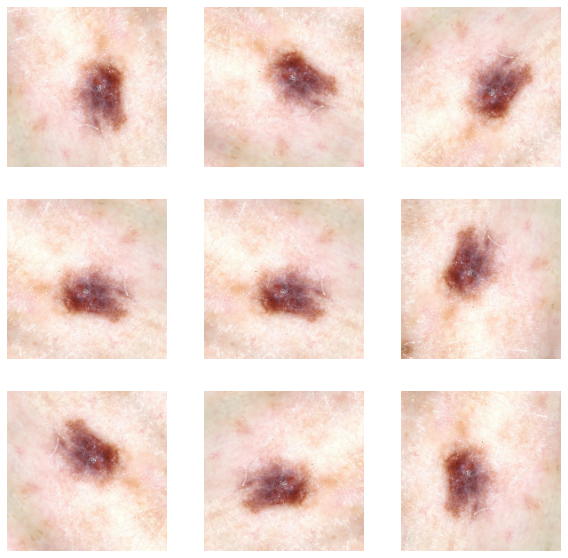

In [61]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [62]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here



## You can use Dropout layer if there is an evidence of overfitting in your findings




model_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])





### Compiling the model

In [63]:
## Your code goes here


model_augmented.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])



### Training the model

In [64]:
## Your code goes here, note: train your model for 20 epochs
## Your code goes here, note: train your model for 20 epochs


## Your code goes here, note: train your model for 20 epochs
epochs = 20
#history = model_augmented.fit(train_ds,epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])
history = model_augmented.fit(train_ds,epochs = epochs, verbose = 1, validation_data=val_ds)

Epoch 1/20
56/56 [==============================] - 7s 87ms/step - loss: 2.2607 - accuracy: 0.1897 - val_loss: 2.0678 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 5s 82ms/step - loss: 2.0354 - accuracy: 0.1975 - val_loss: 2.0401 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 5s 82ms/step - loss: 2.0388 - accuracy: 0.2015 - val_loss: 2.0273 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 5s 83ms/step - loss: 2.0292 - accuracy: 0.1936 - val_loss: 2.0220 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 5s 83ms/step - loss: 2.0272 - accuracy: 0.2148 - val_loss: 2.0252 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 5s 83ms/step - loss: 2.0235 - accuracy: 0.2042 - val_loss: 2.0266 - val_accuracy: 0.1924
Epoch 7/20
56/56 [==============================] - 5s 83ms/step - loss: 2.0229 - accuracy: 0.2037 - val_loss: 2.0218 - val_accuracy: 0.2058
Epoch 8/20
56

### Visualizing the results

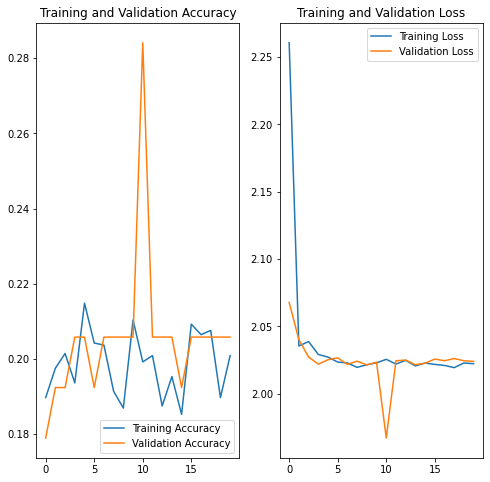

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [66]:
loss, accuracy = model_augmented.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model_augmented.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 20ms/step - loss: 2.0240 - accuracy: 0.2058
Accuracy:  0.2064732164144516
Validation Accuracy:  0.20581655204296112
Loss:  2.014693021774292
Validation Loss 2.0240325927734375


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [67]:


train_path=data_dir_train

for i in class_names:
    directory =str(train_path)+'/'+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


Class Imbalance observed 



   The samples of various classes are not in equal proportion.
    There is a significant Class Imbalance observed.
    
    

*   The class with the least number of samples is Seborrheic Keratosis - 77
*  The class that dominates the data in terms of proportionate number of samples is Pigmented Benign Keratosis with sample size - 462






#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [68]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [69]:



path_to_training_dataset=train_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) +'/'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8CDE63BDD0>: 100%|██████████| 500/500 [00:11<00:00, 42.21 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8CDE75E390>: 100%|██████████| 500/500 [00:14<00:00, 34.48 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8D60090150>: 100%|██████████| 500/500 [00:12<00:00, 40.90 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8CDD677FD0>: 100%|██████████| 500/500 [00:58<00:00,  8.53 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7F8CDD5CD350>: 100%|██████████| 500/500 [00:53<00:00,  9.31 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8CF66F1A90>: 100%|██████████| 500/500 [00:11<00:00, 44.21 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8CDD384FD0>: 100%|██████████| 500/500 [00:24<00:00, 20.64 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8CDE78C850>: 100%|██████████| 500/500 [00:11<00:00, 44.21 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8CDD5CD1D0>: 100%|██████████| 500/500 [00:13<00:00, 38.01 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [70]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [71]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0029889.jpg_7e3eb676-9451-49d6-92ce-ccb4e5303e02.jpg',
 '/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0033450.jpg_86973854-47e1-4149-85c3-a4362efcaee9.jpg',
 '/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0024706.jpg_5793d251-519e-4280-b619-3f2bc2c59e5f.jpg',
 '/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0032614.jpg_0a331d6f-ce06-4e6c-b64d-8da2ae5eb3f9.jpg',
 '/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0031201.jpg_be017c3f-6d66-46d1-9519-c0e1c9de7464.jpg',
 '/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train/vascular lesion/output/vascular lesion_original_ISIC_0031270.jpg_2747c288-ba94-4ca2-bde6-ef6ea

In [72]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [73]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [109]:
print(data_dir_train)

for i in class_names:
    directory =str(data_dir_train)+'/'+i+'/'
    directory_out =str(data_dir_train)+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length_out+length
    print(f'{i} has {length_tot} samples.')


/content/gdrive/MyDrive/ML/CNN/Skin_Cancer_Detection/Train
actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [75]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [76]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [77]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [105]:
model_final=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,(3,3),activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'),
     BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'),
     BatchNormalization(),
     Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'),
     BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [106]:
## your code goes here




model_final.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])



#### **Todo:**  Train your model

In [107]:
epochs = 50
batch_size_final=32

history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size_final,
  epochs=epochs
)


Epoch 1/50
169/169 [==============================] - 29s 151ms/step - loss: 4.7589 - accuracy: 0.3001 - val_loss: 6.7543 - val_accuracy: 0.0943
Epoch 2/50
169/169 [==============================] - 26s 149ms/step - loss: 2.7228 - accuracy: 0.3279 - val_loss: 3.7032 - val_accuracy: 0.1952
Epoch 3/50
169/169 [==============================] - 26s 149ms/step - loss: 2.0021 - accuracy: 0.3637 - val_loss: 2.5999 - val_accuracy: 0.2509
Epoch 4/50
169/169 [==============================] - 26s 149ms/step - loss: 1.8375 - accuracy: 0.3752 - val_loss: 1.9312 - val_accuracy: 0.3497
Epoch 5/50
169/169 [==============================] - 26s 149ms/step - loss: 1.7322 - accuracy: 0.4165 - val_loss: 1.7769 - val_accuracy: 0.3890
Epoch 6/50
169/169 [==============================] - 26s 150ms/step - loss: 2.2212 - accuracy: 0.3913 - val_loss: 1.9285 - val_accuracy: 0.4491
Epoch 7/50
169/169 [==============================] - 26s 150ms/step - loss: 1.7510 - accuracy: 0.4386 - val_loss: 1.6092 - val_ac

#### **Todo:**  Visualize the model results

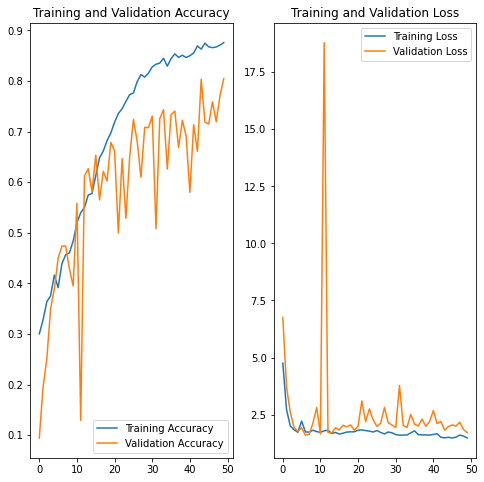

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



    The training accuracy seems to be nearly ~90%.
    The validation accuracy is nearly ~80%.
    Though the model accuracy has improved, the class rebalance has helped treat the overfitting to some extent.
    Much better models could be built or tried out using more epochs and more layers.




In [82]:
pred = model_final.predict(test_ds)

4/4 [==============================] - 15s 38ms/step


In [83]:
pred[0]

array([3.4984726e-01, 3.1997636e-01, 5.8271796e-02, 6.8860129e-05,
       4.1552559e-02, 2.9495584e-03, 1.5890805e-04, 1.6395588e-03,
       2.2553509e-01], dtype=float32)

In [84]:
pred

array([[3.4984726e-01, 3.1997636e-01, 5.8271796e-02, ..., 1.5890805e-04,
        1.6395588e-03, 2.2553509e-01],
       [3.5989896e-04, 5.6411712e-03, 6.0708023e-04, ..., 7.3583724e-05,
        6.4433292e-02, 3.8439097e-04],
       [8.8438950e-03, 6.9896483e-01, 1.6270125e-03, ..., 5.4615866e-05,
        2.3529311e-01, 3.5072092e-02],
       ...,
       [6.9148886e-01, 1.2766042e-03, 1.1250977e-03, ..., 4.6665918e-05,
        1.3808525e-01, 6.8200484e-04],
       [8.0583766e-02, 4.4410813e-04, 1.4868163e-03, ..., 3.3131425e-04,
        7.5271871e-04, 6.4679705e-05],
       [2.1986445e-02, 1.2768822e-03, 2.1797558e-03, ..., 3.3420307e-05,
        7.4223382e-04, 4.0827846e-04]], dtype=float32)